# **Start**

In [ ]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

# Set random seeds
np.random.seed(10)
tf.random.set_seed(10)

In [ ]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load arrays from .npy files (START here if you have the data)
X_images = np.load('/content/drive/My Drive/Colab Notebooks/Dataset/Adv ML Dataset/X_images.npy')
X_masks = np.load('/content/drive/My Drive/Colab Notebooks/Dataset/Adv ML Dataset/X_masks.npy')
y = np.load('/content/drive/My Drive/Colab Notebooks/Dataset/Adv ML Dataset/y.npy')

In [ ]:
# Split data
X_train_val, X_test, X_mask_train_val, X_mask_test, y_train_val, y_test = train_test_split(
    X_images, X_masks, y,
    test_size=0.2,
    stratify=y,
    random_state=10
)

X_train, X_val, X_mask_train, X_mask_val, y_train, y_val = train_test_split(
    X_train_val, X_mask_train_val, y_train_val,
    test_size=0.2,
    stratify=y_train_val,
    random_state=10
)

print("Dataset split sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Verify class distribution in splits
print("\nClass distribution in splits:")
print("Training set:", np.bincount(y_train))
print("Validation set:", np.bincount(y_val))
print("Test set:", np.bincount(y_test))

Dataset split sizes:
Training set: 450 samples
Validation set: 113 samples
Test set: 141 samples

Class distribution in splits:
Training set: [229 221]
Validation set: [58 55]
Test set: [72 69]


# **ResNet Model**

In [ ]:
#3. Using ResNet model
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Add permute
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)  # Add permute
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)  # Add permute
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
from torchvision.models import resnet152, ResNet152_Weights
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim

resnet = resnet152(weights=ResNet152_Weights.DEFAULT)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),  # New fully connected layer
    nn.ReLU(),                # Activation function
    nn.Dropout(0.5),          # Dropout layer
    nn.Linear(128, 2)         # Final output layer
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet.to(device)

# Define optimizer, scheduler, and loss function
LR = 0.01
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
criterion = nn.BCEWithLogitsLoss()

# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect probabilities and labels for AUC calculation
        probs = torch.softmax(outputs, dim=1)[:, 1]
        all_probs.extend(probs.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    epoch_auc = roc_auc_score(np.array(all_labels), np.array(all_probs))
    return epoch_loss, epoch_acc, epoch_auc

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect probabilities and labels for AUC calculation
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    epoch_auc = roc_auc_score(np.array(all_labels), np.array(all_probs))
    return epoch_loss, epoch_acc, epoch_auc, np.array(all_labels), np.array(all_predictions)

In [ ]:
import matplotlib.pyplot as plt
import torch

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
train_aucs = []
val_losses = []
val_accuracies = []
val_aucs = []

# Initialize variables to track the best model
best_val_auc = 0.0
best_model_path = 'best_model.pth'
epochs_without_improvement = 0
epoch_run = 0
patience = 10

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    epoch_run += 1
    train_loss, train_acc, train_auc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_auc, _, _ = evaluate(model, val_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_aucs.append(train_auc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

    # Check for improvement
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with val_auc: {val_auc:.4f}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Early stopping
    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break

    scheduler.step(val_loss)

Epoch 1/50
Train Loss: 0.6755, Train Acc: 0.6289, Train AUC: 0.6569
Val Loss: 0.6961, Val Acc: 0.5133, Val AUC: 0.5978
New best model saved with val_auc: 0.5978
Epoch 2/50
Train Loss: 0.5943, Train Acc: 0.7067, Train AUC: 0.7806
Val Loss: 0.6435, Val Acc: 0.6549, Val AUC: 0.8154
New best model saved with val_auc: 0.8154
Epoch 3/50
Train Loss: 0.5724, Train Acc: 0.7133, Train AUC: 0.7787
Val Loss: 0.6089, Val Acc: 0.7080, Val AUC: 0.8248
New best model saved with val_auc: 0.8248
Epoch 4/50
Train Loss: 0.4762, Train Acc: 0.7933, Train AUC: 0.8460
Val Loss: 0.6039, Val Acc: 0.7611, Val AUC: 0.8351
New best model saved with val_auc: 0.8351
Epoch 5/50
Train Loss: 0.4021, Train Acc: 0.8467, Train AUC: 0.9016
Val Loss: 0.6476, Val Acc: 0.6991, Val AUC: 0.8614
New best model saved with val_auc: 0.8614
Epoch 6/50
Train Loss: 0.3519, Train Acc: 0.8711, Train AUC: 0.9192
Val Loss: 0.5847, Val Acc: 0.7699, Val AUC: 0.7978
Epoch 7/50
Train Loss: 0.3428, Train Acc: 0.8467, Train AUC: 0.9204
Val Loss

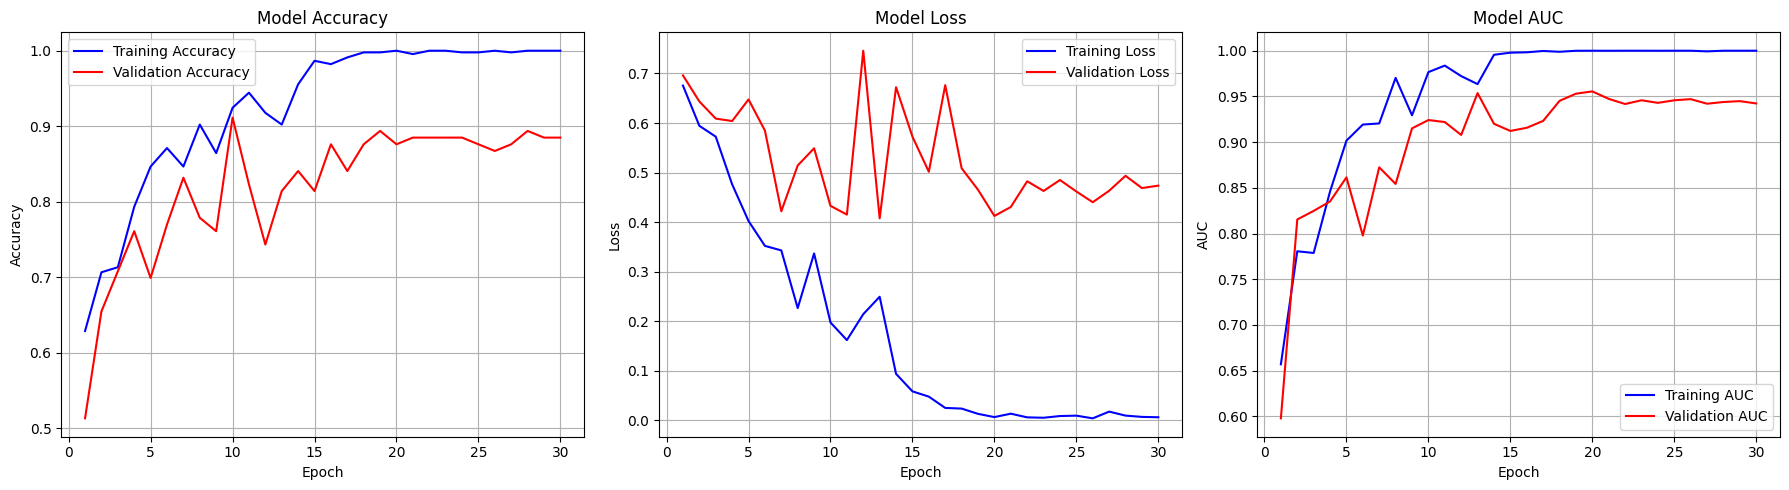

In [ ]:
# Plot accuracy, loss, and AUC
plt.figure(figsize=(18, 5))

epoch_run = len(train_accuracies) + 1

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(range(1, epoch_run), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, epoch_run), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(range(1, epoch_run), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, epoch_run), val_losses, label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(range(1, epoch_run), train_aucs, label='Training AUC', color='blue')
plt.plot(range(1, epoch_run), val_aucs, label='Validation AUC', color='red')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<ipython-input-112-4f51f31dc417>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.94      0.94        72
     Class 1       0.94      0.94      0.94        69

    accuracy                           0.94       141
   macro avg       0.94      0.94      0.94       141
weighted avg       0.94      0.94      0.94       141

Test Metrics:
Test Accuracy: 0.9433
Test Loss: 0.1899


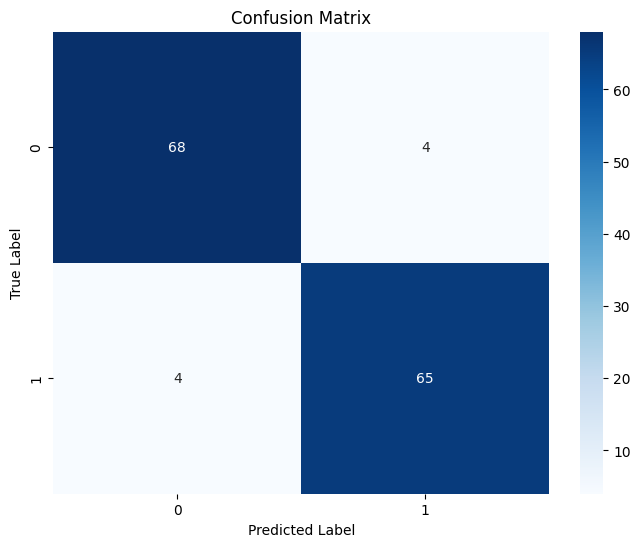

In [ ]:
# Load the best model before testing
model.load_state_dict(torch.load(best_model_path))

# Evaluate on test set
test_loss, test_accuracy, _, test_labels, test_predictions = evaluate(model, test_loader, criterion, device)
report = classification_report(test_labels, test_predictions, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)

# Print testing metrics
print("Test Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# **Fine Tune**

In [ ]:
LR = 0.0003
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.8, weight_decay=1e-5)

Epoch 1/1
Train Loss: 0.0164, Train Acc: 0.9978, Train AUC: 1.0000
Val Loss: 0.4781, Val Acc: 0.8761, Val AUC: 0.9260
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.94      0.90        72
     Class 1       0.94      0.84      0.89        69

    accuracy                           0.89       141
   macro avg       0.90      0.89      0.89       141
weighted avg       0.90      0.89      0.89       141

Test Metrics:
Test Accuracy: 0.8936
Test Loss: 0.2772


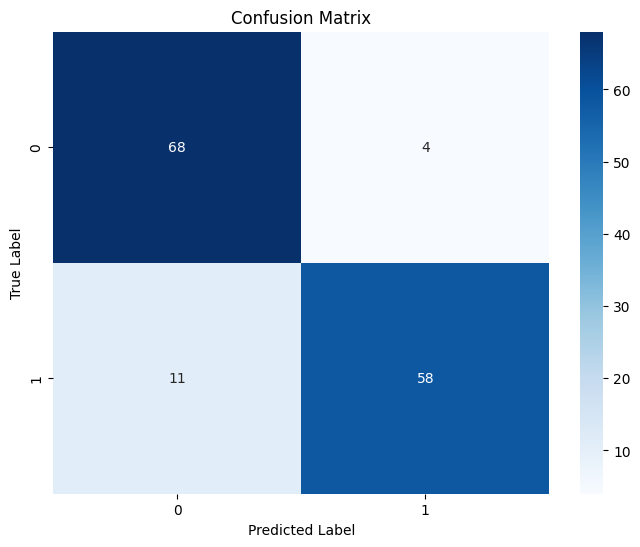

In [ ]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    train_loss, train_acc, train_auc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_auc, _, _ = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

    scheduler.step(val_loss)

# Evaluate on test set
test_loss, test_accuracy, _, test_labels, test_predictions = evaluate(model, test_loader, criterion, device)
report = classification_report(test_labels, test_predictions, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)

# Print testing metrics
print("Test Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Dump GPU Cache

In [ ]:
# Dump GPU Cache
import torch
import gc

# Assuming `model`, `optimizer`, and other training-related variables are no longer needed
del model
del optimizer
del train_loader
del val_loader

# If you have any other large tensors or variables, delete them as well
# del any_other_large_variable

# Manually run garbage collection
gc.collect()

# Empty the CUDA cache
torch.cuda.empty_cache()


In [ ]:
torch.save(model.state_dict(), 'my_resnet_model.pth')